<a id='top'></a>

<a href='#import'>Import &amp; Inspect</a> | <a href='#logreg'>Logistic Regression</a> | <a href='#rf'>Random Forest</a> | <a href='#xgb'>XGBoost</a> | <a href='#lme'>Linear Mixed Effects</a> | <a href='#merf'>Mixed Effects Random Forest</a> | <a href='#best'>Best Model/Dedicated Users</a> | <a href='#summary'>Summary &amp; Conclusions</a>
    
<br>

---


# Predicting Mastery in Academic Assessments - Machine Learning Analysis
Students taking advantage of practice exercises through software applications seek an evaluation of their preparedness for formal academic assessments. The goal of this project is to help test developers understand user progress by predicting whether a student answers the next test question correctly.

# Data Wrangling
The [Initial Data Exploration](http://nbviewer.jupyter.org/github/humburgc/academic_mastery_study/blob/master/notebooks/initial_data_exploration.ipynb?flush_cache=true) notebook contains the following work:

Download the `grockit_all_data.zip` file from the [Grockit competition on Kaggle](https://www.kaggle.com/c/WhatDoYouKnow/data). Import and inspect raw training data. Isolate relevant variables, fill or calculate new variables, and organize the dataframe. Resolve missing, invalid, corrupted or duplicate values.

From that notebook, the clean dataframe was saved in the file `clean_training.csv`, which is used for EDA.

---
# Exploratory Data Analysis
The [Exploratory Data Analysis]() notebook contains the following work:

Create data visualizations to explain variables. Detect and possibly remove or mark outliers. Explore variable dependence and correlations. Consider a hypothesis to explore. Leverage statistical inference to test the hypothesis. More generally, begin to develop a preliminary likeness of the solution

As it was determined that test groups are independent, and the GMAT group provides the most data, it is used here to predict user outcome and hopefully provide more insight for test developers. 


---
# Machine Learning Analysis
The `clean_gmat.csv` file saved at the end of EDA is used here to train the models.

Build, fit, and validate a method to model the data. Evaluate the performance of each model tested, including Logistic Regression, Random Forest, Linear Mixed Effects, Mixed Effects Random Forest, XGBoost.

<a href='#top' id='import'>back to menu</a>

## Import & Inspect

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn.model_selection
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import time
from time import localtime, strftime

print(strftime('%H:%M:%S', localtime()))

import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import xgboost as xgb

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('poster')

# Set options to inspect ALL of the columns:
pd.options.display.max_columns = 375

22:03:32


In [2]:
def snap_probabilities(p):
    if p >= 0.5:
        return 1
    else:
        return 0

def cbd(y, predicted):
    """Return the capped binomial deviance for true and predicted values."""
    predicted[predicted < 0.01] = 0.01
    predicted[predicted > 0.99] = 0.99
    return np.mean(-(y*np.log10(predicted)+(1-y)*np.log10(1-predicted)))
    

In [3]:
def model_summary(y_test, predictions, probabilities, model_name='model_name'):
    
    accuracy = np.mean(predictions == np.array(y_test))
    CBD = cbd(y_test, probabilities)

    model_name = pd.DataFrame({'model_name': model_name, 'Accuracy': round(accuracy, 4), 'CBD': round(CBD, 4)}, index=[0])
    model_name = model_name[['model_name', 'Accuracy', 'CBD']]
    
    return model_name

---
## GMAT DATASET

In [4]:
# Read and save CSV file a as dataframe:
gmat = pd.read_csv('../data/interim/clean_gmat.csv').drop('Unnamed: 0', axis='columns')

# Convert round_duration and total_practice to timedelta:
gmat['round_duration'] = pd.to_timedelta(gmat.round_duration, unit='s').astype(int)
gmat['total_practice'] = pd.to_timedelta(gmat.total_practice, unit='s').astype(int)

gmat = gmat[['user_id', 'question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts', 'num_questions', 'total_practice', 'correct']]
gmat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371385 entries, 0 to 2371384
Data columns (total 11 columns):
user_id           int64
question_id       int64
track_name        int64
subtrack_name     int64
game_type         int64
num_players       int64
round_duration    int64
prior_attempts    int64
num_questions     int64
total_practice    int64
correct           int64
dtypes: int64(11)
memory usage: 199.0 MB


In [5]:
gmat.head()

,user_id,question_id,track_name,subtrack_name,game_type,num_players,round_duration,prior_attempts,num_questions,total_practice,correct
0,85818,5560,5,14,7,1,65000000000,0,315,27762000000000,0
1,85818,4681,5,0,7,1,82000000000,0,315,27762000000000,1
2,85818,1529,5,0,7,1,74000000000,0,315,27762000000000,1
3,85818,2908,5,0,7,1,62000000000,0,315,27762000000000,1
4,85818,1773,5,11,7,1,177000000000,0,315,27762000000000,1


### Determine Best Training Sample Size

In [6]:
gmat_sample = gmat.sample(1000000, weights=gmat.user_id, axis=0, random_state=0)
len(gmat_sample)

1000000

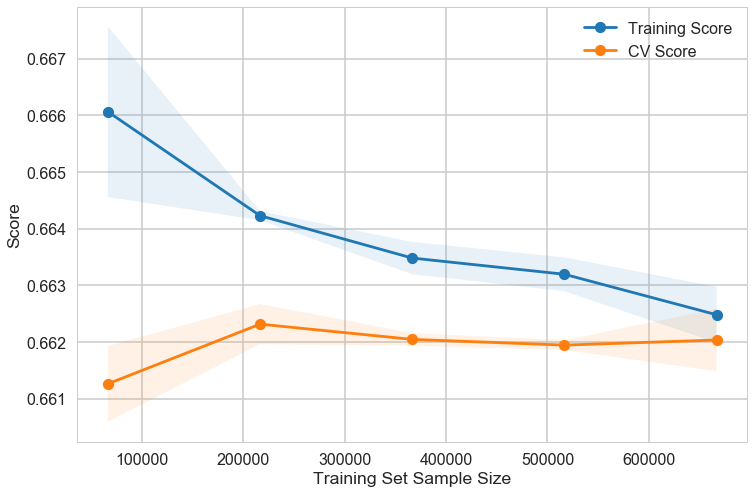

In [7]:
warnings.filterwarnings('ignore')

X_train = gmat_sample.drop('correct', axis=1)
y_train = (gmat_sample.correct).values

train_sizes, train_scores, cv_scores = learning_curve(
    xgb.XGBClassifier(objective='binary:logistic'), 
    X_train, y_train, 
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
cv_scores_mean = np.mean(cv_scores, axis=1)
cv_scores_std = np.std(cv_scores, axis=1)
    
fig = plt.figure(figsize=(12,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.plot(train_sizes, cv_scores_mean, 'o-', label='CV Score')

plt.xlabel('Training Set Sample Size')
plt.ylabel('Score')
plt.legend(loc='best');

In [8]:
gmat_sample = gmat.sample(250000, weights=gmat.user_id, axis=0, random_state=0)
len(gmat_sample)

250000

In [9]:
X = gmat_sample.drop('correct', axis=1)
y = gmat_sample.correct

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

<a href='#top' id='logreg'>back to menu</a>

## Logistic Regression

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create the pipeline:
pipe = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression())])

# Create grid of hyperparameters:
grid = {'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
       'logistic__penalty': ['l1', 'l2']}

# Instantiate GridSearchCV with pipeline and hyperparameters:
clf = GridSearchCV(pipe, grid, cv=10)

start = time()
print('Started at:', strftime('%H:%M:%S', localtime()))

clf.fit(X_train, y_train)

end = time()
print('fit-time: {:0.1f} minutes'.format((end-start)/60))
print()


logistic = clf.best_estimator_.named_steps['logistic']


predictions = clf.predict(X_test)
probabilities = clf.predict_proba(X_test)[:, 1]

logistic_regression = model_summary(y_test, predictions, probabilities, model_name='logistic_regression')
logistic_regression[['Accuracy', 'CBD']]

Started at: 22:12:14
fit-time: 4.1 minutes



,Accuracy,CBD
0,0.6164,0.2889


This is not the appropriate algorithm for this task. Logistic Regression assumes that observations are independent, which is not true for this project. 

But it's fast!

<a href='#top' id='rf'>back to menu</a>

## Random Forest
This creates an ensemble of decision trees which are averaged to improve prediction accuracy, and it scores how important each feature was for classification.

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=-1)
param_grid = {
    'n_estimators': [8, 16, 24, 32],
    'min_samples_leaf': [1, 6, 12, 24, 30],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10)

start = time()
print('Started at:', strftime('%H:%M:%S', localtime()))

grid_search.fit(X_train, y_train)

end = time()
print('fit-time: {:0.1f} minutes'.format((end-start)/60))
print()

clf = RandomForestClassifier(**grid_search.best_params_, n_jobs=-1)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
probabilities = clf.predict_proba(X_test)[:, 1]

random_forest = model_summary(y_test, predictions, probabilities, model_name='random_forest')
random_forest[['Accuracy', 'CBD']]

Started at: 22:16:18
fit-time: 61.2 minutes



,Accuracy,CBD
0,0.6687,0.2554


In [13]:
all_models = pd.concat([logistic_regression, random_forest])

feature_importances = dict(list(zip(X_train, clf.feature_importances_)))
pd.DataFrame.from_dict(feature_importances, orient='index', columns=['Importance']).sort_values(by=['Importance'], ascending=False)

,Importance
round_duration,0.441546
total_practice,0.129700
num_questions,0.128291
question_id,0.098653
user_id,0.075829
subtrack_name,0.048266
game_type,0.035989
num_players,0.016510
track_name,0.012826
prior_attempts,0.012391


<a href='#top' id='xgb'>back to menu</a>

---
## XGBoost
This implements gradient boosted decision trees, and scales very well to many samples. It works by iteratively learning a set of weak models on subsets of the data, weighing each weak prediction according to each weak model's performance, and combining the weighted predictions to obtain a single weighted prediction.

In [14]:
warnings.filterwarnings('ignore')
import xgboost as xgb

param_grid = {
    'max_depth': [5, 10, 20],
    'min_child_weight': [1, 5, 10],
    'colsample_bytree': [0.25, 0.5, 0.75, 1],
    'gamma': [1, 5, 10]
}

# Instantiate classifier:
clf = xgb.XGBClassifier(objective='binary:logistic')

# Search and Fit:
search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=4, verbose=1)

start = time()
print('Started at:', strftime('%H:%M:%S', localtime()))

search.fit(X_train, y_train)

end = time()

print("Best Parameters: ", search.best_params_)

Started at: 23:17:47
Fitting 4 folds for each of 108 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 241.9min finished


fit-time: 242.3 minutes

Best Parameters:  {'colsample_bytree': 0.25, 'gamma': 1, 'max_depth': 20, 'min_child_weight': 5}


In [15]:
clf = xgb.XGBClassifier(**search.best_params_, objective='binary:logistic', n_jobs=-1)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
probabilities = clf.predict_proba(X_test)[:, 1]

xgboost = model_summary(y_test, predictions, probabilities, model_name='xgboost')
all_models = pd.concat([all_models, xgboost])
xgboost[['Accuracy', 'CBD']]

,Accuracy,CBD
0,0.6983,0.2454


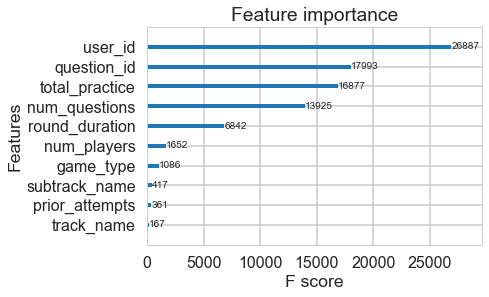

In [16]:
xgb.plot_importance(clf);

<a href='#top' id='lme'>back to menu</a>

## Linear Mixed Effects
These models are useful for analyzing data that are dependent, hierarchical, or longitudinal. The tracks and subtracks suggest hierarchy and there is certainly a longitudinal nature of observations by user.

In [17]:
train, test = train_test_split(gmat_sample, train_size=0.8, random_state=0)

In [18]:
X_train = train.drop(['correct', 'user_id'], axis=1)
y_train = train.correct
g_train = train.user_id

X_test = test.drop(['correct', 'user_id'], axis=1)
y_test = test.correct
g_test = test.user_id

In [19]:
start = time()
print('Started at:', strftime("%H:%M:%S", localtime()))

model = sm.MixedLM(y_train, X_train, g_train).fit()

end = time()
print('fit-time: {:0.1f} minutes'.format((end-start)/60))
print()

probabilities = model.predict(X_test)
predictions = np.vectorize(snap_probabilities)(probabilities)

linear_mixed_effects = model_summary(y_test, predictions, probabilities, model_name='linear_mixed_effects')
all_models = pd.concat([all_models, linear_mixed_effects])
linear_mixed_effects[['Accuracy', 'CBD']]

Started at: 03:20:38
fit-time: 3.8 minutes



,Accuracy,CBD
0,0.5692,0.3017


<a href='#top' id='merf'>back to menu</a>

## Mixed Effects Random Forest
A method developed by a group of statisticians to account for mixed effects while using Random Forest as the estimator.

* Article penned by the developers: https://towardsdatascience.com/mixed-effects-random-forests-6ecbb85cb177
 
 
* MERF repository: https://github.com/manifoldai/merf

In [20]:
from merf.merf import MERF
merf = MERF(max_iterations=40)

In [21]:
Z_train = np.ones((len(X_train), 1))

Z_test = np.ones((len(X_test), 1))

In [22]:
start = time()
print('Started at:', strftime("%H:%M:%S", localtime()))

model = merf.fit(X_train, Z_train, g_train, y_train)

end = time()
print('fit-time: {:0.1f} minutes'.format((end-start)/60))
print()

probabilities = model.predict(X_test, Z_test, g_test)
predictions = np.vectorize(snap_probabilities)(probabilities)

mixed_effects_randforest = model_summary(y_test, predictions, probabilities, model_name='mixed_effects_randforest')
all_models = pd.concat([all_models, mixed_effects_randforest])
mixed_effects_randforest[['Accuracy', 'CBD']]

Started at: 03:24:28


INFO     [merf.py:235] GLL is -153657.55943870117 at iteration 1.
INFO     [merf.py:235] GLL is -193085.1360003708 at iteration 2.
INFO     [merf.py:235] GLL is -206084.5683104036 at iteration 3.
INFO     [merf.py:235] GLL is -213256.78592747622 at iteration 4.
INFO     [merf.py:235] GLL is -218785.58184568814 at iteration 5.
INFO     [merf.py:235] GLL is -223139.65827645402 at iteration 6.
INFO     [merf.py:235] GLL is -226578.03180873123 at iteration 7.
INFO     [merf.py:235] GLL is -229604.1038548499 at iteration 8.
INFO     [merf.py:235] GLL is -232185.06601577433 at iteration 9.
INFO     [merf.py:235] GLL is -234165.21099366597 at iteration 10.
INFO     [merf.py:235] GLL is -236142.66511588808 at iteration 11.
INFO     [merf.py:235] GLL is -237778.54586785918 at iteration 12.
INFO     [merf.py:235] GLL is -239166.09951499035 at iteration 13.
INFO     [merf.py:235] GLL is -240709.81766487806 at iteration 14.
INFO     [merf.py:235] GLL is -241916.36366340864 at iteration 15.
INFO   

fit-time: 293.4 minutes



,Accuracy,CBD
0,0.6683,0.2583


## Summary of GMAT Models

In [23]:
compare_models = all_models.copy()
compare_models.set_index('model_name', inplace=True)
compare_models.sort_values(by=['Accuracy'], ascending=False)

,Accuracy,CBD
model_name,,
xgboost,0.6983,0.2454
random_forest,0.6687,0.2554
mixed_effects_randforest,0.6683,0.2583
logistic_regression,0.6164,0.2889
linear_mixed_effects,0.5692,0.3017


<a href='#top' id='best'>back to menu</a>

## Best Model with Dedicated Users Only

In [24]:
atleast_30 = gmat.groupby('user_id').filter(lambda x: x['user_id'].count() >= 30)
len(atleast_30)

1920898

In [25]:
gmat_sample = atleast_30.sample(250000, weights=gmat.user_id, axis=0, random_state=0)
len(gmat_sample)

250000

In [26]:
X = gmat_sample.drop('correct', axis=1)
y = gmat_sample.correct

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [28]:
warnings.filterwarnings('ignore')
import xgboost as xgb

param_grid = {
    'max_depth': [5, 10, 20],
    'min_child_weight': [1, 5, 10],
    'colsample_bytree': [0.25, 0.5, 0.75, 1]
}

# Instantiate classifier:
clf = xgb.XGBClassifier(objective='binary:logistic')

# Search and Fit:
search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=4, verbose=1)

start = time()
print('Started at:', strftime('%H:%M:%S', localtime()))

search.fit(X_train, y_train)

end = time()

print("Best Parameters: ", search.best_params_)

Started at: 08:34:35
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 82.4min finished


fit-time: 82.8 minutes

Best Parameters:  {'colsample_bytree': 0.25, 'max_depth': 20, 'min_child_weight': 5}


In [29]:
clf = xgb.XGBClassifier(**search.best_params_, objective='binary:logistic', n_jobs=-1)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
probabilities = clf.predict_proba(X_test)[:, 1]

xgboost_30 = model_summary(y_test, predictions, probabilities, model_name='xgboost_30')
all_models = pd.concat([all_models, xgboost_30])
xgboost_30[['Accuracy', 'CBD']]

,Accuracy,CBD
0,0.7109,0.2411


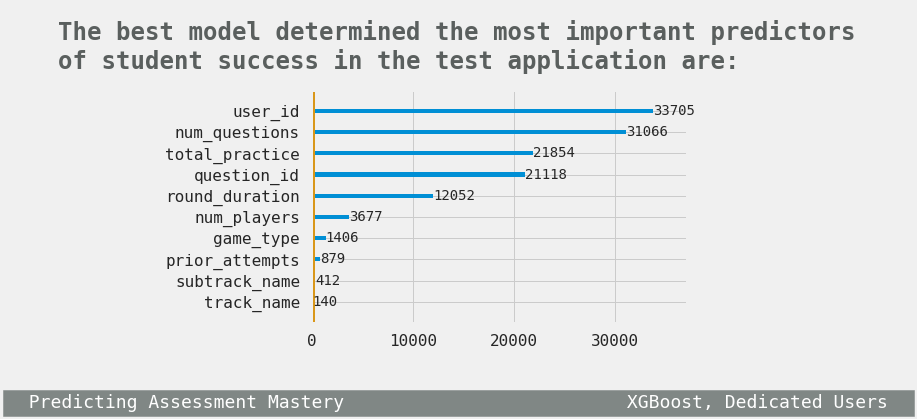

In [39]:
# Create bar plot for outcome distribution:
plt.style.use('fivethirtyeight')
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'

# fig, ax = plt.subplots(figsize=(12, 8))
features_grph = xgb.plot_importance(clf)
features_grph.axvline(x=0, color='#D9971A', linewidth=7)

# Create axis labels and the title:
features_grph.xaxis.label.set_visible(False)
features_grph.yaxis.label.set_visible(False)
features_grph.title.set_visible(False)
features_grph.text(x=-30000, y=-5, 
                  s='  Predicting Assessment Mastery                          XGBoost, Dedicated Users  ', 
                  fontsize=18, color='#ffffff', backgroundcolor='#808785')

# Add a title bar with some space at the top:
features_grph.text(x=0, y=13, s=' ', fontsize=24)
features_grph.text(x=-25000, y=11, s='The best model determined the most important predictors\nof student success in the test application are:', fontsize=24, weight='bold', color='#5A5F5E')

# Save and display the plot:
plt.savefig('../reports/figures/strongest_features.png', bbox_inches='tight');

In [31]:
print(strftime('%H:%M:%S', localtime()))

09:58:01


<a href='#top' id='summary'>back to menu</a>

---
## SUMMARY & CONCLUSIONS

In [32]:
compare_models = all_models.copy()
compare_models.set_index('model_name', inplace=True)
compare_models.sort_values(by=['Accuracy'], ascending=False)

,Accuracy,CBD
model_name,,
xgboost_30,0.7109,0.2411
xgboost,0.6983,0.2454
random_forest,0.6687,0.2554
mixed_effects_randforest,0.6683,0.2583
logistic_regression,0.6164,0.2889
linear_mixed_effects,0.5692,0.3017


Exploratory data analysis and machine learning back up the intuition that the more a user practices the more successful they are in answering questions. More importantly, both show that dedicated users provide enough data for a more reliable analysis of their performance. Features related to subject matter and ‘game’ structure were less helpful as predictors. 

### Recommendation to Test Developers: 
To better understand user progress and improve test applications, developers are encouraged to incentivize users to attempt at least 30 questions.

---
## [Final Report](https://github.com/humburgc/predicting_assessment_mastery/blob/master/reports/final_report.pdf)


## [Presentation](https://github.com/humburgc/predicting_assessment_mastery/blob/master/reports/presentation.pdf)

<br>